In [1]:
path_to_muograph = "../"
import sys
sys.path.insert(1, path_to_muograph)

%reload_ext autoreload
%autoreload 2

![alternative text](../images/muograph_logo.png)


**<h1><center>Binned Clustered Algorithm: tutorial</center></h1>**

The `BCA` class is used to compute voxelized **scattering density predictions** based on the **Binned Clustered Algorithm** (A binned clustering algorithm  to detect high-Z material using cosmic muons, 2013 JINST 8 P10013, (http://iopscience.iop.org/1748-0221/8/10/P10013))

### **I - Initialization** 

First, let's instanciante the `TrackingMST` class. At first, we will consider a detector with perfect **spatial resolution** and **efficiency**:

In [2]:
csv_file = '../muograph/data/iron_barrel/barrel_and_cubes_scattering.csv'

from muograph.hits.hits import Hits

hits_in = Hits(
    data = csv_file,  # The csv file
    plane_labels = (0, 1, 2),  # Include hits from first planes 0, 1 and 2
    input_unit = "mm",  # The distance unit in the csv file.
)
hits_out = Hits(
    data = csv_file,  # The csv file
    plane_labels = (3, 4, 5),  # Include hits from first planes 0, 1 and 2
    input_unit = "mm",  # The distance unit in the csv file.
)

hits_in, hits_out

GPU is not available. Using CPU


(Collection of hits from 137,033 muons on 3 detector panels.,
 Collection of hits from 137,033 muons on 3 detector panels.)

In [3]:
from muograph.tracking.tracking import Tracking

tracks_in = Tracking(label="above", hits=hits_in)
tracks_out = Tracking(label="below", hits=hits_out)

tracks_in, tracks_out


(Collection of tracks from 137,033 muons 
  with perfect angular resolution.,
 Collection of tracks from 137,033 muons 
  with perfect angular resolution.)

In [4]:
output_dir = "../output_test/"
from muograph.tracking.tracking import TrackingMST
mst = TrackingMST(trackings=(tracks_in, tracks_out))
mst

Collection of tracks from 137,033 muons 
 with perfect angular resolution.
 with perfect tracking efficiency

The `BCA` class takes the following **arguments**:


- `tracking (Optional[TrackingMST])`: Instance of the TrackingMST class.

- `voi (Volume)`: Instance of the Volume class.

- `output_dir (Optional[str])`: Path to a directory where to save POCA attributes in a hdf5 file.

In [5]:
from muograph.volume.volume import Volume
voi = Volume(
    position = (0, 0, -1200), # The position of the Volume of interest.
    dimension = (1000, 600, 600), # The dimensions of the Volume of interest.
    voxel_width = (20, 20, 20)) # The voxel size.

In [6]:
from muograph.reconstruction.binned_clustered import BCA
bca = BCA(tracking=mst, voi=voi, output_dir="../output_test/")

../output_test directory created


Class attributes saved at ../output_test/poca.hdf5


### I - **BCA scattering density predictions**

The **BCA algorithm** is designed to compute voxel-wize **scattering density predictions**, using **POCA**, **scattering angle** and muon **momentum** information (if available).

**Initialization:**

 - Associate an **empty list** $L$ to **each voxel**.

 - **Filters out** muons with **scattering angle** $\delta\theta$ outside of the desired range `dtheta_range`.

 - **Filters out** muons with **momentum** $p$ outside of the desired range `momentum_range` (if momentum is available).

**Voxel scan:**

- For each voxel $v$:
  - Only keep the POCA points having the $N_{max}$ largest scattering angles (`n_max_per_vox`).
  - If the number of POCA points in $v$ is greater than $N_{min}$ (`n_min_per_vox`):
    - For each **pair** of **POCA** points $i, j$ in $v$:
      - Computes $m_{ij} = \frac{(\Delta\theta_i p_i) * (\Delta\theta_j p_j)}{d_{ij}}$, where $d_{ij}$ is the geometrical distance between the POCA $_i$ and POCA $_j$, $\Delta\theta$ the scattering angle and $p$ the momentum.
      - Append $f(m_{ij})$ to the voxel's list $L_v$, where $f$ is the `metric_method` function (natural $log$ by default).
  - Else append 0 to $L_v$.

**At the end of the scan**

For each voxel $v$:

- Computes the **final** voxel's **score** $S_v$ as a function of the voxel's list $L_v$: $S_v = g(L_v)$, where $g$ is the `score_method`. By default, $g$  the **median function**. 

In [7]:
bca.params

BCAParams(n_max_per_vox=50, n_min_per_vox=3, score_method=functools.partial(<built-in method quantile of type object at 0x7f2af6fdba20>, q=0.5), metric_method=functools.partial(<built-in method log of type object at 0x7f2af6fdba20>), p_range=(0.0, 10000000), dtheta_range=(0.0, 1.0471975511965976), use_p=False, p_clamp=0.999, dtheta_clamp=0.999)

Similarly to `POCA.n_poca_per_vox`, the BCA scattering density predictions `BCA.xyz_voxel_pred` is a  $(n_x, n_y, n_z)$ array of `floats`, where $n_i$ is the number of voxels along the $i$ direction.

In [8]:
bca.xyz_voxel_pred, bca.xyz_voxel_pred.shape

(tensor([[[-18.3814, -18.3814, -18.3814,  ..., -18.3814, -18.3814, -18.3814],
          [-18.3814, -18.3814, -18.3814,  ..., -18.3814, -18.3814, -18.3814],
          [-18.3814, -18.3814, -18.3814,  ..., -18.3814, -18.3814, -18.3814],
          ...,
          [-18.3814, -18.3814, -18.3814,  ..., -18.3814, -18.3814, -18.3814],
          [-18.3814, -18.3814, -18.3814,  ..., -18.3814, -18.3814, -18.3814],
          [-18.3814, -18.3814, -18.3814,  ..., -18.3814, -18.3814, -18.3814]],
 
         [[-18.3814, -18.3814, -18.3814,  ..., -18.3814, -18.3814, -18.3814],
          [-18.3814, -18.3814, -18.3814,  ..., -18.3814, -18.3814, -18.3814],
          [-18.3814, -18.3814, -18.3814,  ..., -18.3814, -18.3814, -18.3814],
          ...,
          [-18.3814, -18.3814, -18.3814,  ..., -18.3814, -18.3814, -18.3814],
          [-18.3814, -18.3814, -18.3814,  ..., -18.3814, -18.3814, -18.3814],
          [-18.3814, -18.3814, -18.3814,  ..., -18.3814, -18.3814, -18.3814]],
 
         [[-18.3814, -18.381

Let's have a look at the BCA scattering density predictions. They are stored in the `BCA.xyz_voxel_pred` feature.

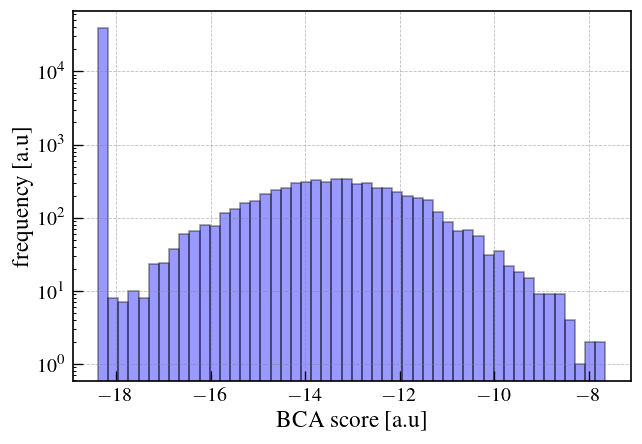

In [9]:
from muograph.plotting.plotting import plot_hist
plot_hist(bca.xyz_voxel_pred.ravel(), xlabel="BCA score [a.u]", logy=True)

As the `BCA` class also **inherits** from the `VoxelPlotting` class, it comes with dedicated methods to **plot voxelized data**.

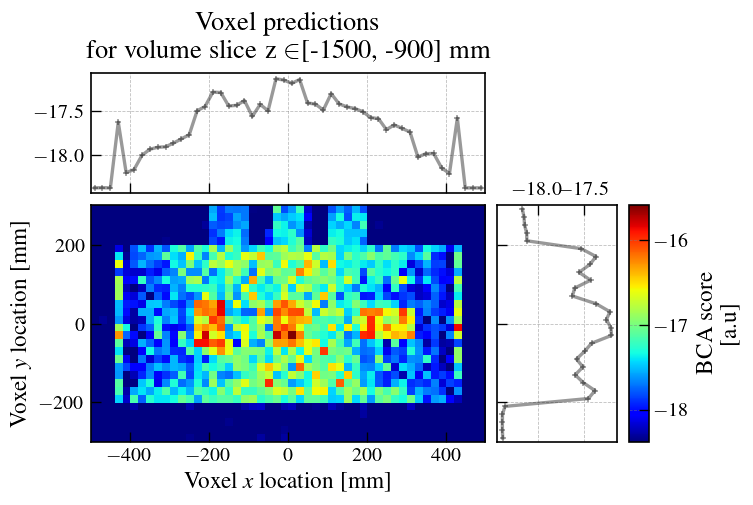

In [10]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 2 

bca.plot_pred_slice(
    voi=voi,  # The volume of interest
    xyz_voxel_preds=bca.xyz_voxel_pred,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim = dim, # The dimension to project along
    figname = "../output_test/bca_default_preds_all_volume", # The name of the figure to save
    pred_label="BCA score",
    pred_unit="\n[a.u]",
)

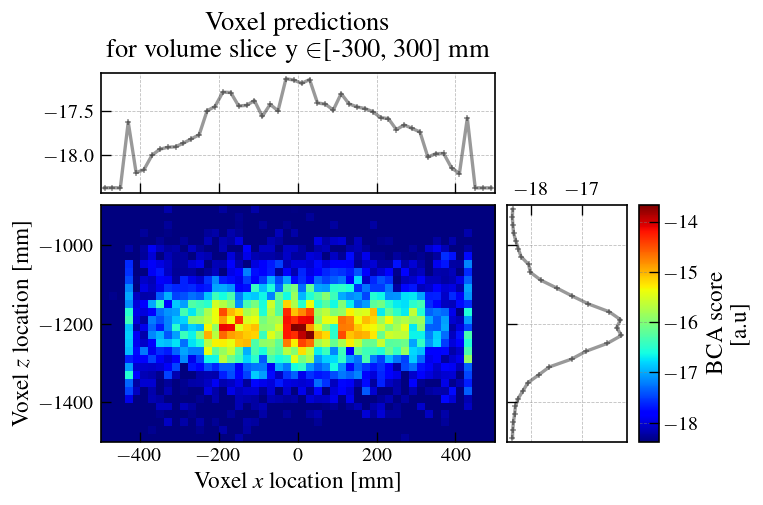

In [11]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 1

bca.plot_pred_slice(
    voi=voi,  # The volume of interest
    xyz_voxel_preds=bca.xyz_voxel_pred,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim = dim, # The dimension to project along
    figname = "../output_test/bca_default_preds_all_volume", # The name of the figure to save
    pred_label="BCA score",
    pred_unit="\n[a.u]",
)

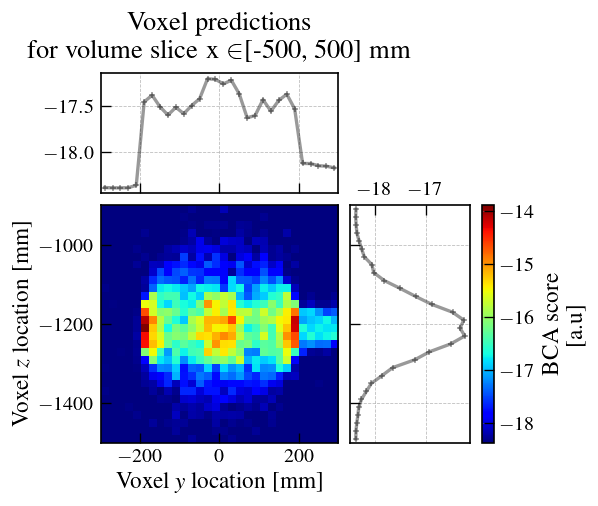

In [12]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 0

bca.plot_pred_slice(
    voi=voi,  # The volume of interest
    xyz_voxel_preds=bca.xyz_voxel_pred,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim = dim, # The dimension to project along
    figname = "../output_test/bca_default_preds_all_volume", # The name of the figure to save
    pred_label="BCA score",
    pred_unit="\n[a.u]",
)

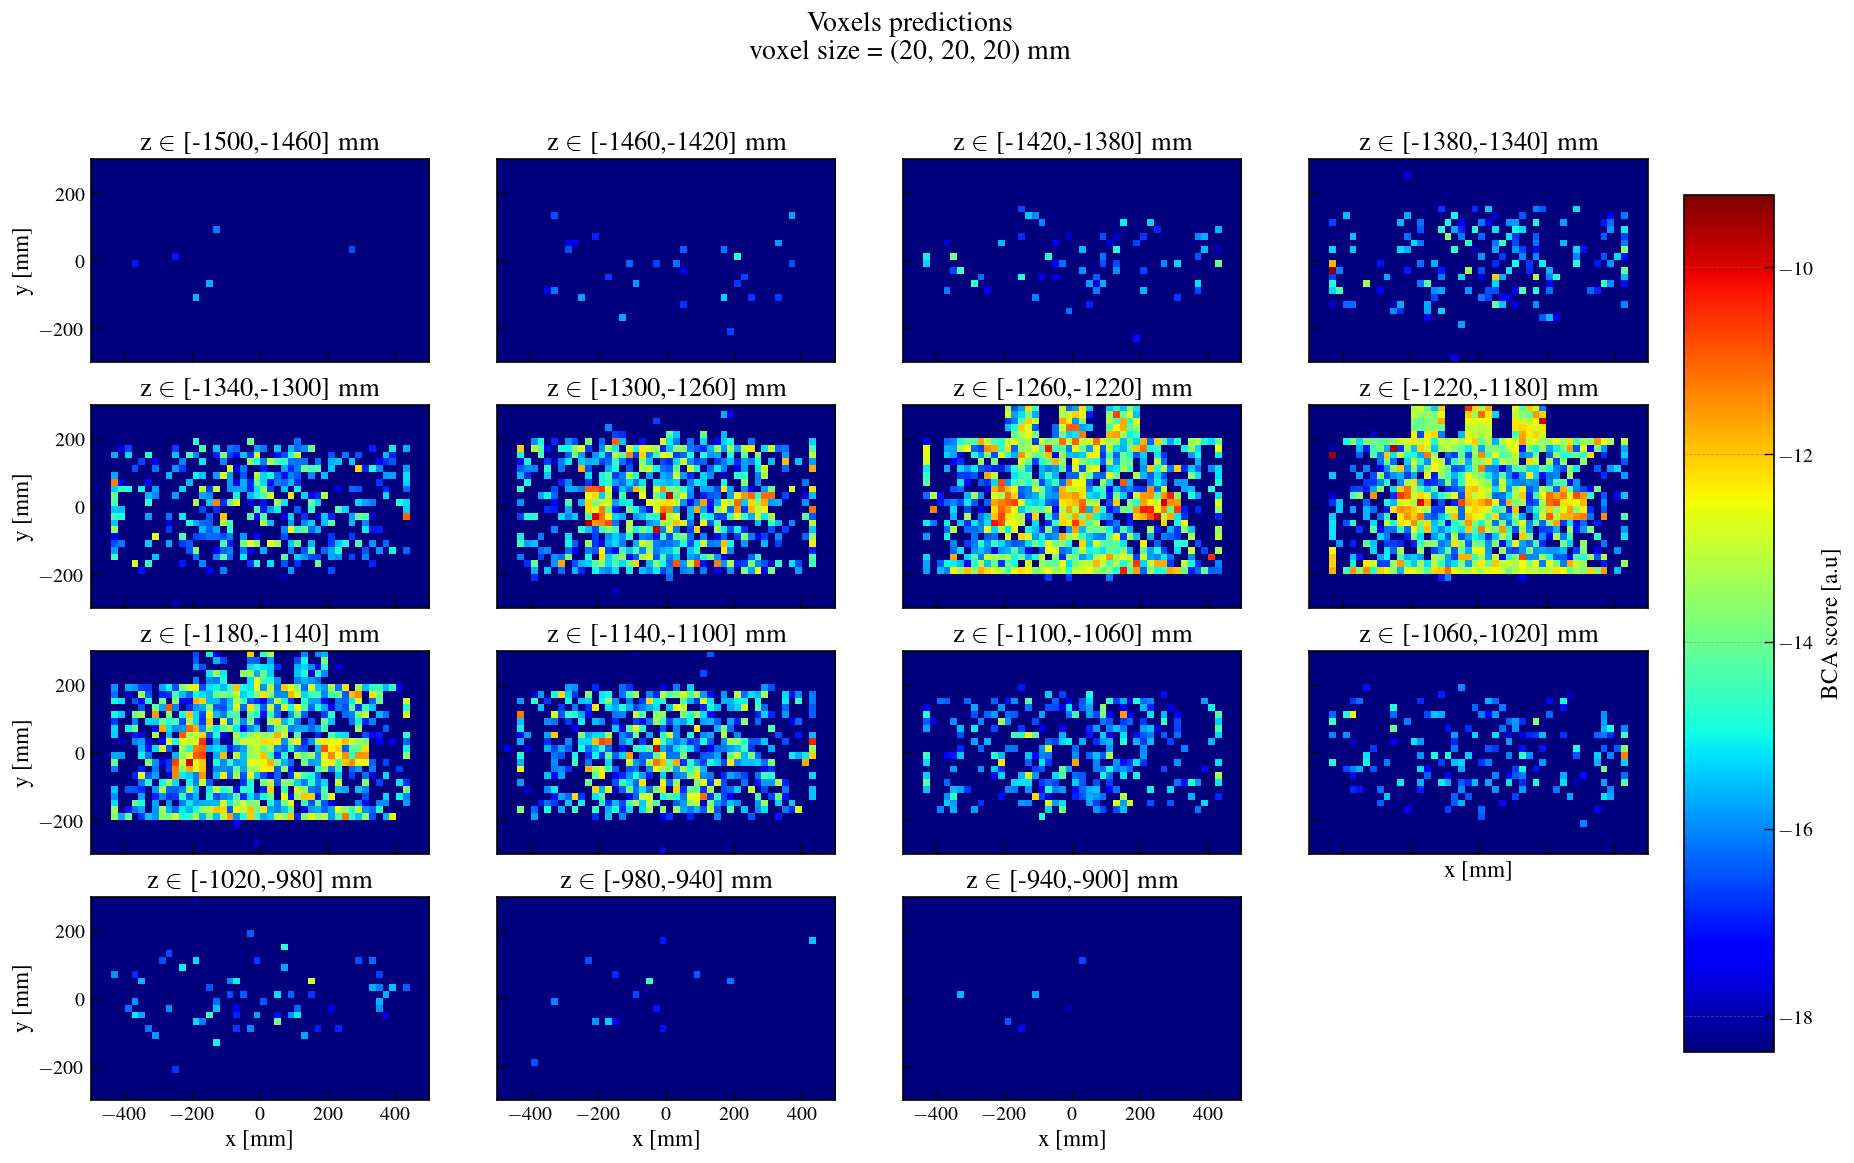

In [13]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 2

bca.plot_pred_by_slice(
    voi=voi, # The volume of interest
    xyz_voxel_preds=bca.xyz_voxel_pred,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim=dim,  # The dimension to project along
    nslice_per_plot=2, # The number of slice per plot
    ncols=4, # The number of columns of the plot
    pred_unit="[a.u]",
    pred_label="BCA score",
    figname = "../output_test/bca_default_preds_slice"
)


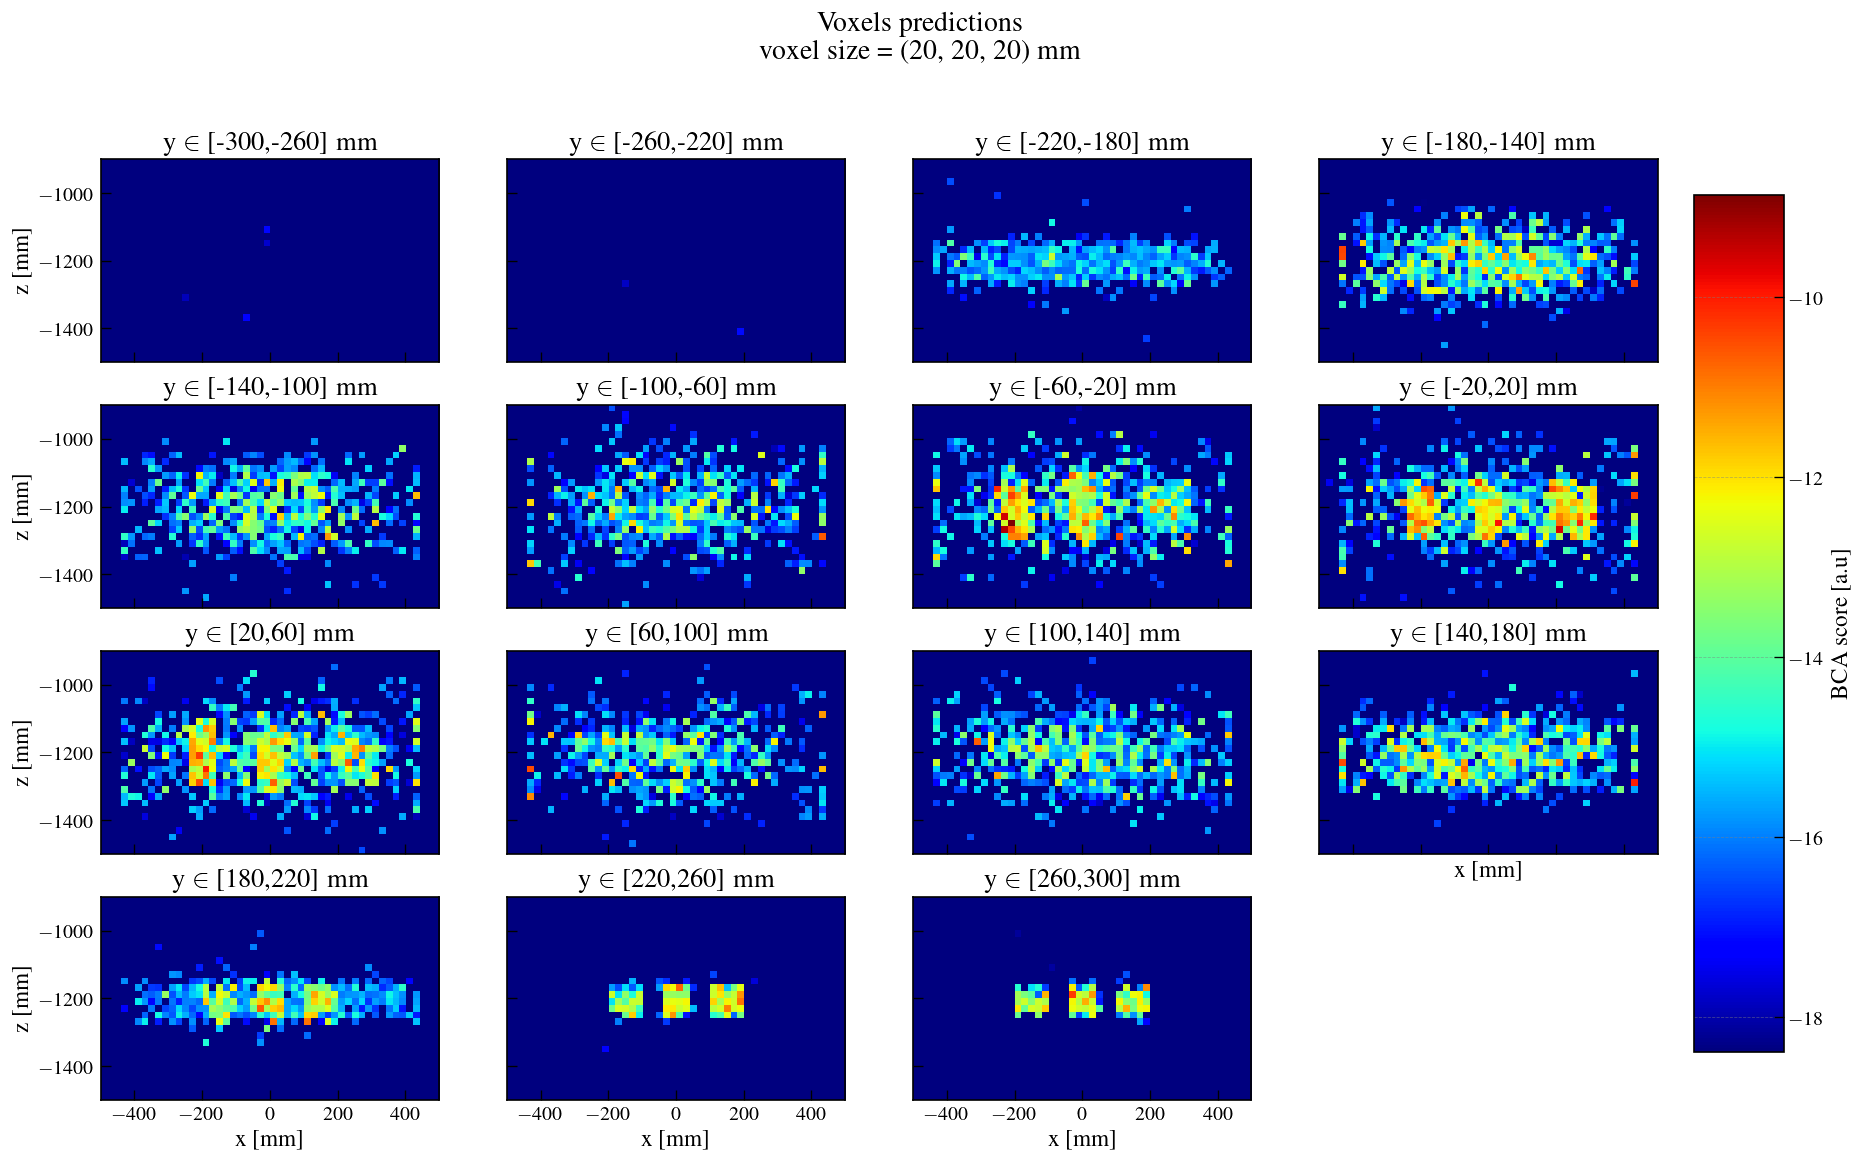

In [14]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 1

bca.plot_pred_by_slice(
    voi=voi, # The volume of interest
    xyz_voxel_preds=bca.xyz_voxel_pred,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim=dim,  # The dimension to project along
    nslice_per_plot=2, # The number of slice per plot
    ncols=4, # The number of columns of the plot
    pred_unit="[a.u]",
    pred_label="BCA score",
    figname = "../output_test/bca_default_preds_slice"
)

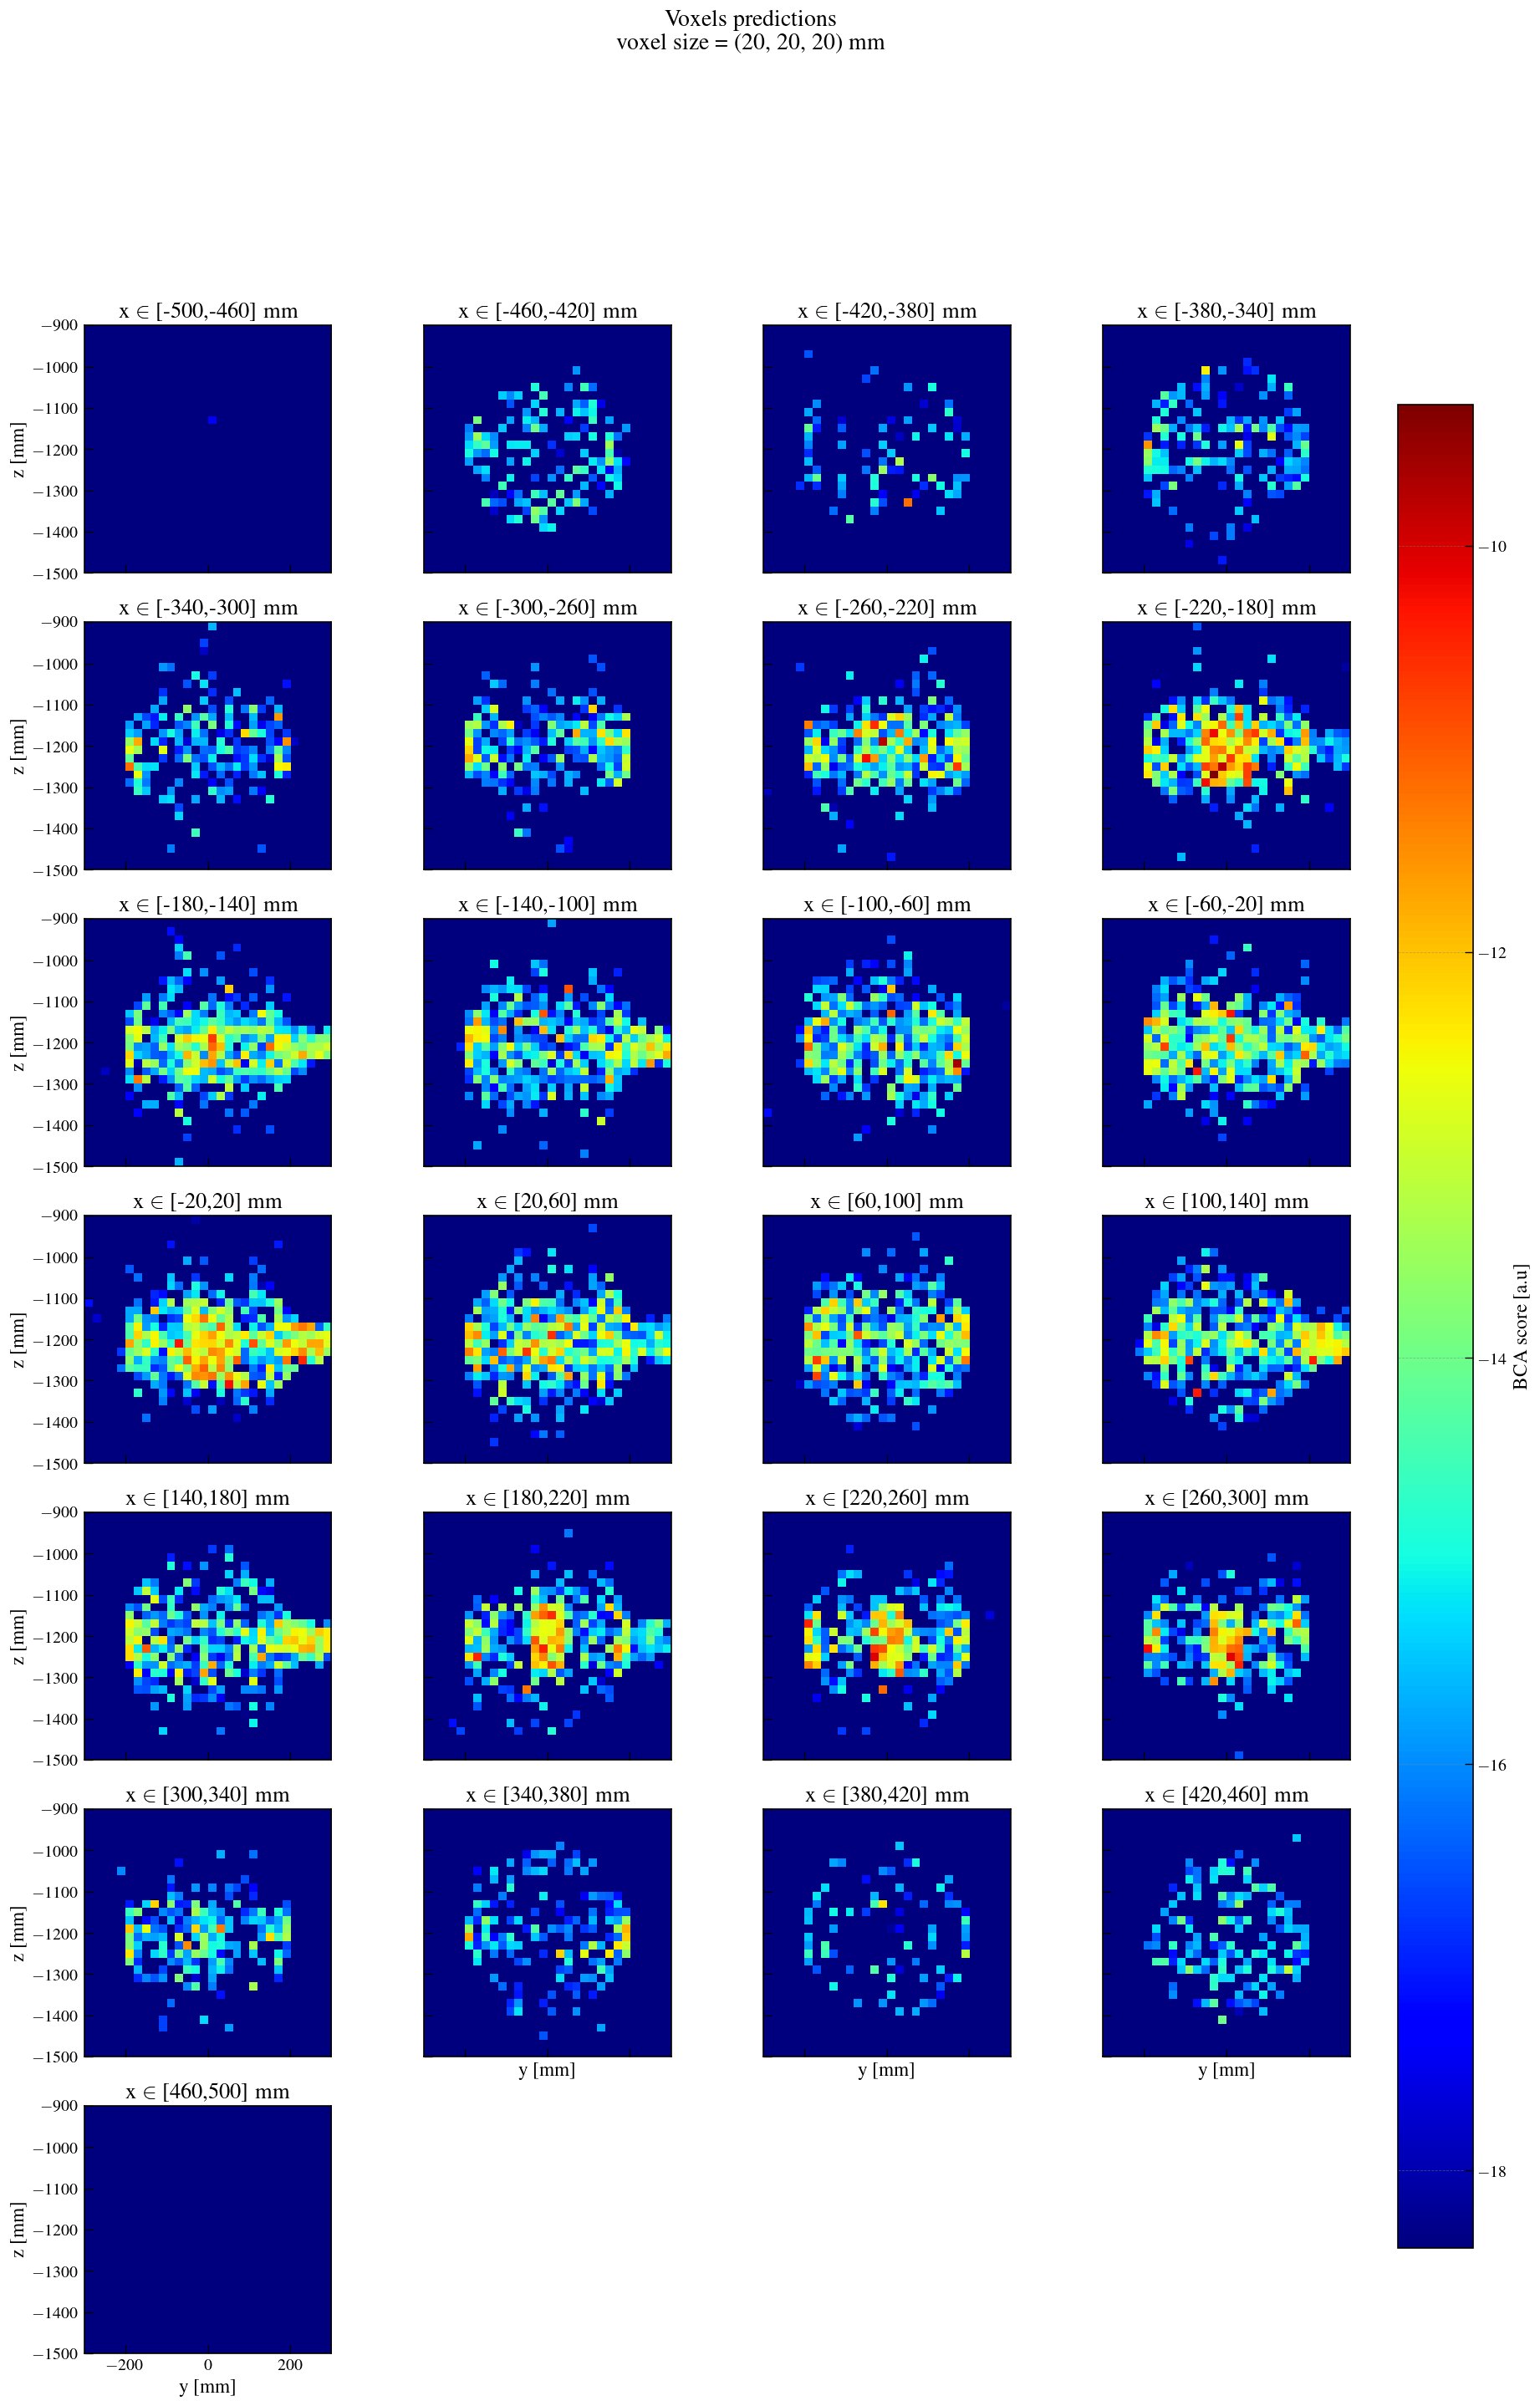

In [15]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 0

bca.plot_pred_by_slice(
    voi=voi, # The volume of interest
    xyz_voxel_preds=bca.xyz_voxel_pred,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim=dim,  # The dimension to project along
    nslice_per_plot=2, # The number of slice per plot
    ncols=4, # The number of columns of the plot
    pred_unit="[a.u]",
    pred_label="BCA score",
    figname = "../output_test/bca_default_preds_slice"
)


The **parameters** of the **algorithm** are stored in the `params` attribute:

In [16]:
bca.params

BCAParams(n_max_per_vox=50, n_min_per_vox=3, score_method=functools.partial(<built-in method quantile of type object at 0x7f2af6fdba20>, q=0.5), metric_method=functools.partial(<built-in method log of type object at 0x7f2af6fdba20>), p_range=(0.0, 10000000), dtheta_range=(0.0, 1.0471975511965976), use_p=False, p_clamp=0.999, dtheta_clamp=0.999)

If the parameters of the algo. are modified, the `xyz_voxel_pred` are automatically re-computed.

Let's set the `use_p` parameter to `True`, and **use** the **momentum information** in the **computation** of the scattering density **predictions**.

In [17]:
from functools import partial
import torch
import math
from muograph.reconstruction.binned_clustered import BCAParams

bca.params = BCAParams(
    n_max_per_vox=50,
    n_min_per_vox=2,
    score_method=partial(torch.quantile, q=0.7),
    metric_method=partial(torch.log),
    p_range=(0.0, 10_000_000),  # MeV
    dtheta_range=(0.1 * math.pi / 180, math.pi / 3),
    use_p=True,
)

Let's have a look at the new predictions:

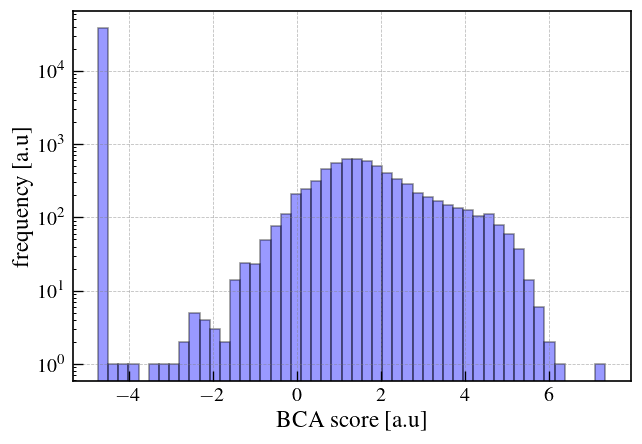

In [18]:
from muograph.plotting.plotting import plot_hist
plot_hist(bca.xyz_voxel_pred.ravel(), xlabel="BCA score [a.u]", logy=True)

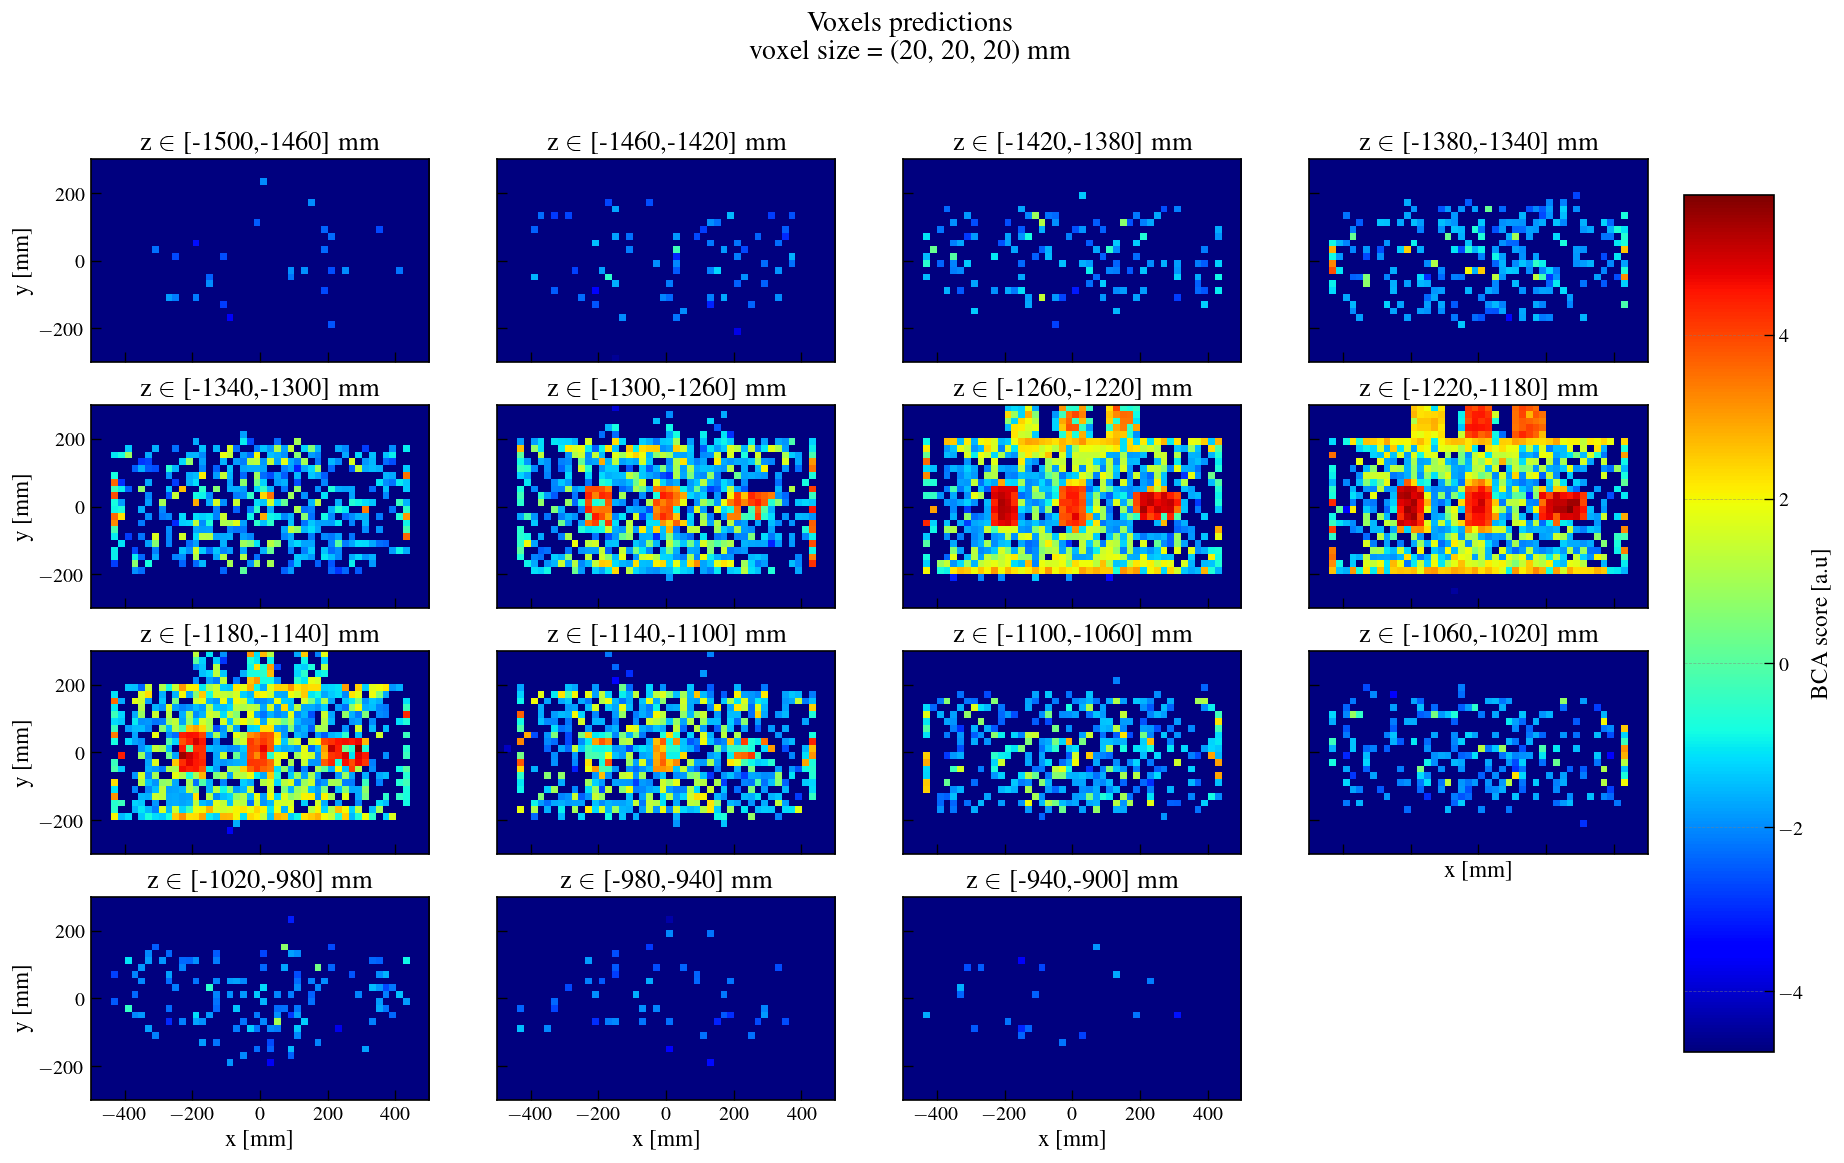

In [19]:
dim = 2

bca.plot_pred_by_slice(
    voi=voi, # The volume of interest
    xyz_voxel_preds=bca.xyz_voxel_pred,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim=dim,  # The dimension to project along
    nslice_per_plot=2, # The number of slice per plot
    ncols=4, # The number of columns of the plot
    pred_unit="[a.u]",
    pred_label="BCA score",
    reverse=False, # Reverse color scale
    figname = "../output_test/bca_default_preds_use_p_slice"
)

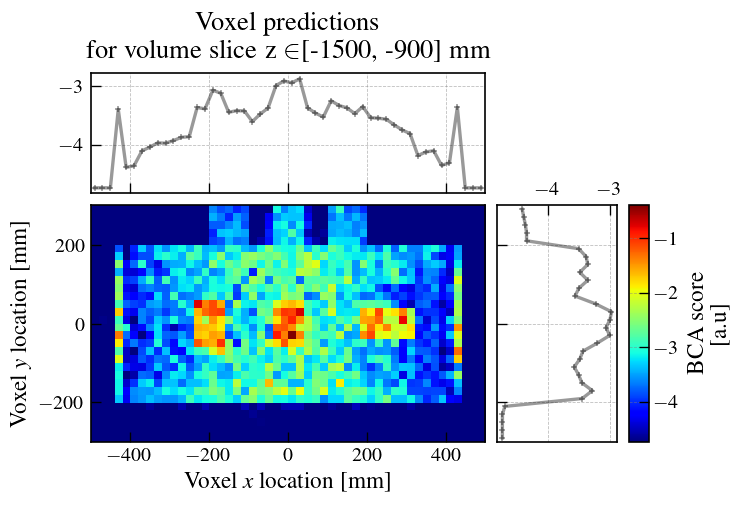

In [20]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 2 

bca.plot_pred_slice(
    voi=voi,  # The volume of interest
    xyz_voxel_preds=bca.xyz_voxel_pred,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim = dim, # The dimension to project along
    figname = "../output_test/bca_default_preds_use_p_all_volume", # The name of the figure to save
    pred_label="BCA score",
    pred_unit="\n[a.u]",
)